In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pathlib


import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision

import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [3]:
batch_size_train = 128
batch_size_test = 16
img_size = 32

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(img_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x*255)
])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=True, download= True, transform=transform),
    batch_size = batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform),
    batch_size = batch_size_test, shuffle=False
)

100%|██████████| 9912422/9912422 [00:00<00:00, 232292497.73it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 4375341.10it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 62333406.01it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18531642.77it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([16, 1, 32, 32])


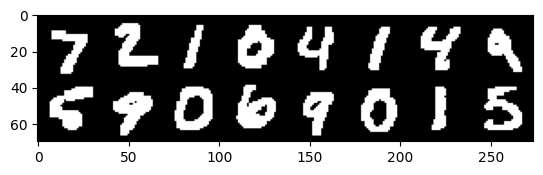

In [4]:
def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

dataiter = iter(test_loader)
images, lables = next(dataiter)
print(images.shape)

imshow(torchvision.utils.make_grid(images))

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


class RotNet(nn.Module):
  def __init__(self):
    super(RotNet, self).__init__()
    # CNN with LeNet Structure
    self.encoder = nn.Sequential(
      nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = (5,5)),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = (2,2), stride = 2),
      nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5,5)),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = (2,2), stride = 2),
      nn.Flatten(),
      nn.Linear(in_features = 16 * 5 * 5, out_features = 120),
      nn.ReLU(),
      nn.Linear(in_features = 120, out_features = 84),
      nn.ReLU(),
      nn.Linear(in_features = 84, out_features = 10)
    )
    self.fc = nn.Linear(10, 4)  # Output for rotation prediction (4 classes)

  def forward(self, x):
    x = self.encoder(x)
    x = self.fc(x)
    return x

def rot(x):
  thetas = [0, 90, 180, 270]
  theta = np.random.choice(thetas)
  return transforms.functional.rotate(x, int(theta)), thetas.index(theta)


In [7]:
from tqdm import tqdm

saved_params_path = "./saved_params_rotnet"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

num_epochs = 50
lr = 3e-4

rot_model = RotNet().to(device)
print(rot_model)

CE_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(rot_model.parameters(), lr=lr)

for epoch in tqdm(range(num_epochs)):
  for batch_idx, (x, labels) in enumerate(train_loader, 0):
    x = x.to(device)
    labels = labels.to(device)

    rot_img = []
    rot_degrees = []

    for img in x:
      img = img
      # unsqueeze to add channel
      img = img.unsqueeze(0)
      img, theta = rot(img)
      rot_img.append(img)
      rot_degrees.append(torch.tensor(theta))

    x = torch.cat(rot_img, dim =0)
    theta = torch.stack(rot_degrees)

    x = x.to(device)
    theta = theta.to(device)

    optimizer.zero_grad()
    outputs = rot_model.forward(x)

    loss = CE_loss(outputs, theta)
    loss.backward()
    optimizer.step()

  print(f"Epoch {epoch+1}/{num_epochs}, Cross Entropy Loss: {loss.item():.2f}")
  torch.save(rot_model.state_dict(), f'{saved_params_path}/{epoch}.pth')

# Save the trained model
torch.save(rot_model.state_dict(), 'final_rot.pth')

RotNet(
  (encoder): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
  (fc): Linear(in_features=10, out_features=4, bias=True)
)


  2%|▏         | 1/50 [00:35<28:40, 35.11s/it]

Epoch 1/50, Cross Entropy Loss: 0.08


  4%|▍         | 2/50 [01:10<28:25, 35.53s/it]

Epoch 2/50, Cross Entropy Loss: 0.09


  6%|▌         | 3/50 [01:45<27:39, 35.31s/it]

Epoch 3/50, Cross Entropy Loss: 0.03


  8%|▊         | 4/50 [02:20<26:57, 35.16s/it]

Epoch 4/50, Cross Entropy Loss: 0.03


 10%|█         | 5/50 [02:55<26:05, 34.78s/it]

Epoch 5/50, Cross Entropy Loss: 0.04


 12%|█▏        | 6/50 [03:29<25:32, 34.83s/it]

Epoch 6/50, Cross Entropy Loss: 0.02


 14%|█▍        | 7/50 [04:04<24:54, 34.76s/it]

Epoch 7/50, Cross Entropy Loss: 0.06


 16%|█▌        | 8/50 [04:39<24:17, 34.70s/it]

Epoch 8/50, Cross Entropy Loss: 0.05


 18%|█▊        | 9/50 [05:13<23:34, 34.51s/it]

Epoch 9/50, Cross Entropy Loss: 0.01


 20%|██        | 10/50 [05:49<23:24, 35.11s/it]

Epoch 10/50, Cross Entropy Loss: 0.04


 22%|██▏       | 11/50 [06:24<22:43, 34.95s/it]

Epoch 11/50, Cross Entropy Loss: 0.08


 24%|██▍       | 12/50 [06:59<22:06, 34.91s/it]

Epoch 12/50, Cross Entropy Loss: 0.01


 26%|██▌       | 13/50 [07:33<21:21, 34.65s/it]

Epoch 13/50, Cross Entropy Loss: 0.00


 28%|██▊       | 14/50 [08:07<20:46, 34.63s/it]

Epoch 14/50, Cross Entropy Loss: 0.05


 30%|███       | 15/50 [08:42<20:13, 34.67s/it]

Epoch 15/50, Cross Entropy Loss: 0.03


 32%|███▏      | 16/50 [09:16<19:35, 34.56s/it]

Epoch 16/50, Cross Entropy Loss: 0.00


 34%|███▍      | 17/50 [09:51<18:59, 34.53s/it]

Epoch 17/50, Cross Entropy Loss: 0.02


 36%|███▌      | 18/50 [10:26<18:28, 34.65s/it]

Epoch 18/50, Cross Entropy Loss: 0.01


 38%|███▊      | 19/50 [11:00<17:51, 34.57s/it]

Epoch 19/50, Cross Entropy Loss: 0.01


 40%|████      | 20/50 [11:34<17:15, 34.51s/it]

Epoch 20/50, Cross Entropy Loss: 0.04


 42%|████▏     | 21/50 [12:09<16:37, 34.41s/it]

Epoch 21/50, Cross Entropy Loss: 0.05


 44%|████▍     | 22/50 [12:43<16:05, 34.49s/it]

Epoch 22/50, Cross Entropy Loss: 0.04


 46%|████▌     | 23/50 [13:18<15:33, 34.59s/it]

Epoch 23/50, Cross Entropy Loss: 0.00


 48%|████▊     | 24/50 [13:53<15:01, 34.69s/it]

Epoch 24/50, Cross Entropy Loss: 0.03


 50%|█████     | 25/50 [14:27<14:23, 34.55s/it]

Epoch 25/50, Cross Entropy Loss: 0.06


 52%|█████▏    | 26/50 [15:02<13:51, 34.63s/it]

Epoch 26/50, Cross Entropy Loss: 0.02


 54%|█████▍    | 27/50 [15:38<13:23, 34.94s/it]

Epoch 27/50, Cross Entropy Loss: 0.00


 56%|█████▌    | 28/50 [16:12<12:47, 34.88s/it]

Epoch 28/50, Cross Entropy Loss: 0.04


 58%|█████▊    | 29/50 [16:47<12:07, 34.66s/it]

Epoch 29/50, Cross Entropy Loss: 0.00


 60%|██████    | 30/50 [17:21<11:32, 34.63s/it]

Epoch 30/50, Cross Entropy Loss: 0.00


 62%|██████▏   | 31/50 [17:56<10:59, 34.72s/it]

Epoch 31/50, Cross Entropy Loss: 0.01


 64%|██████▍   | 32/50 [18:31<10:27, 34.85s/it]

Epoch 32/50, Cross Entropy Loss: 0.01


 66%|██████▌   | 33/50 [19:05<09:48, 34.64s/it]

Epoch 33/50, Cross Entropy Loss: 0.00


 68%|██████▊   | 34/50 [19:40<09:13, 34.57s/it]

Epoch 34/50, Cross Entropy Loss: 0.05


 70%|███████   | 35/50 [20:14<08:38, 34.58s/it]

Epoch 35/50, Cross Entropy Loss: 0.00


 72%|███████▏  | 36/50 [20:49<08:05, 34.65s/it]

Epoch 36/50, Cross Entropy Loss: 0.00


 74%|███████▍  | 37/50 [21:23<07:26, 34.38s/it]

Epoch 37/50, Cross Entropy Loss: 0.00


 76%|███████▌  | 38/50 [21:58<06:53, 34.46s/it]

Epoch 38/50, Cross Entropy Loss: 0.01


 78%|███████▊  | 39/50 [22:32<06:19, 34.52s/it]

Epoch 39/50, Cross Entropy Loss: 0.00


 80%|████████  | 40/50 [23:07<05:45, 34.55s/it]

Epoch 40/50, Cross Entropy Loss: 0.00


 82%|████████▏ | 41/50 [23:41<05:09, 34.36s/it]

Epoch 41/50, Cross Entropy Loss: 0.03


 84%|████████▍ | 42/50 [24:15<04:35, 34.43s/it]

Epoch 42/50, Cross Entropy Loss: 0.00


 86%|████████▌ | 43/50 [24:50<04:01, 34.55s/it]

Epoch 43/50, Cross Entropy Loss: 0.00


 88%|████████▊ | 44/50 [25:25<03:27, 34.52s/it]

Epoch 44/50, Cross Entropy Loss: 0.00


 90%|█████████ | 45/50 [26:00<02:54, 34.84s/it]

Epoch 45/50, Cross Entropy Loss: 0.08


 92%|█████████▏| 46/50 [26:34<02:18, 34.64s/it]

Epoch 46/50, Cross Entropy Loss: 0.00


 94%|█████████▍| 47/50 [27:09<01:44, 34.68s/it]

Epoch 47/50, Cross Entropy Loss: 0.00


 96%|█████████▌| 48/50 [27:44<01:09, 34.65s/it]

Epoch 48/50, Cross Entropy Loss: 0.02


 98%|█████████▊| 49/50 [28:18<00:34, 34.52s/it]

Epoch 49/50, Cross Entropy Loss: 0.00


100%|██████████| 50/50 [28:53<00:00, 34.66s/it]

Epoch 50/50, Cross Entropy Loss: 0.00


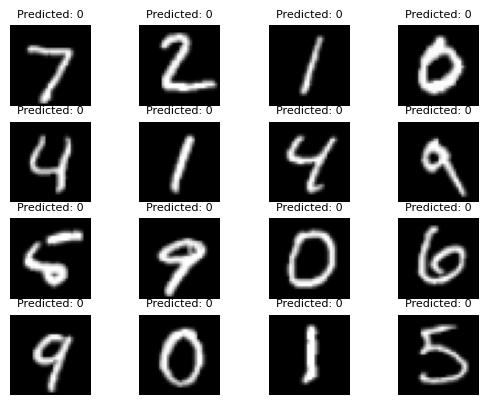

Accuracy : 99.42%


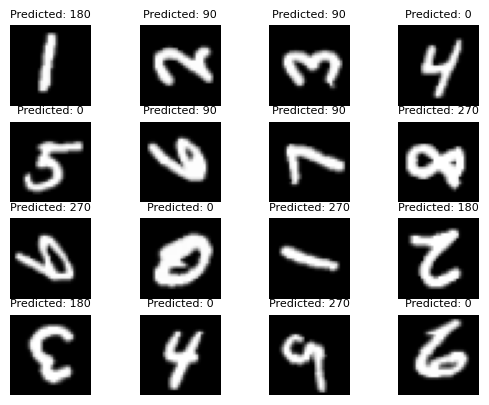

In [8]:
theta = [0, 90, 180, 270]

rot_model.eval()

batch = next(iter(test_loader))
images, labels = batch

outputs = rot_model(images.to(device))
_, prediction = torch.max(outputs.data, 1)

for i in range(16):
  image = images[i].numpy().squeeze()
  plt.subplot(4,4, i+1)
  plt.imshow(image, cmap='gray')
  plt.title(f'Predicted: {theta[prediction[i]]}', fontsize= 8)
  plt.axis('off')
plt.show()

with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
    labels = labels.to(device)
    images = images.to(device)

    rot_img = []
    rot_degrees = []

    for img in images:
      img = img
      # unsqueeze to add channel
      img = img.unsqueeze(0)
      img, theta = rot(img)
      rot_img.append(img)
      rot_degrees.append(torch.tensor(theta))

    x = torch.cat(rot_img, dim =0)
    theta = torch.stack(rot_degrees)

    x = x.to(device)
    theta = theta.to(device)

    outputs = rot_model(x.to(device))
    _, prediction = torch.max(outputs.data, 1)
    total += theta.size(0)
    correct += (prediction == theta).sum().item()
  print(f'Accuracy : {100 * correct / total}%')

theta = [0, 90, 180, 270]

for i in range(16):
  image = x[i].cpu().numpy().squeeze()
  plt.subplot(4,4, i+1)
  plt.imshow(image, cmap='gray')
  plt.title(f'Predicted: {theta[prediction[i]]}', fontsize= 8)
  plt.axis('off')
plt.show()

### w/ CIFAR-10 Dataset

In [5]:
import torchvision.transforms as transforms

transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 29644157.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


torch.Size([16, 3, 32, 32])
  cat   dog horse  ship  ship  bird  ship plane   cat  deer horse horse plane  deer   cat   cat


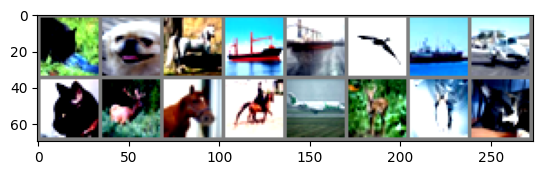

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter =  iter(trainloader)
images, labels = next(dataiter)
print(images.size())

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(images.shape[0])))

### greyscale -> RBG (in_channel 1->3)

In [32]:
rot_model = RotNet().to(device)
rot_model.load_state_dict(torch.load('final_rot.pth',map_location=device))

rot_model.eval()
rot_model.encoder = nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = (5,5)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2,2), stride = 2),
    nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5,5)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = (2,2), stride = 2),
    nn.Flatten(),
    nn.Linear(in_features = 16 * 5 * 5, out_features = 120),
    nn.ReLU(),
    nn.Linear(in_features = 120, out_features = 84),
    nn.ReLU(),
    nn.Linear(in_features = 84, out_features = 10)
  )
rot_model = rot_model.to(device)
print(rot_model)


RotNet(
  (encoder): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
  (fc): Linear(in_features=10, out_features=4, bias=True)
)


In [33]:
from tqdm import tqdm

saved_params_path = "./saved_params_cifar_rotnet"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)

num_epochs = 50
lr = 3e-4

CE_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(rot_model.parameters(), lr=lr)

for epoch in tqdm(range(num_epochs)):
  for batch_idx, (x, labels) in enumerate(trainloader, 0):
    x = x.to(device)
    labels = labels.to(device)

    rot_img = []
    rot_degrees = []

    for img in x:
      img = img
      # unsqueeze to add channel
      img = img.unsqueeze(0)
      img, theta = rot(img)
      rot_img.append(img)
      rot_degrees.append(torch.tensor(theta))

    x = torch.cat(rot_img, dim =0)
    theta = torch.stack(rot_degrees)

    x = x.to(device)
    theta = theta.to(device)

    optimizer.zero_grad()
    outputs = rot_model.forward(x)

    loss = CE_loss(outputs, theta)
    loss.backward()
    optimizer.step()

  print(f"Epoch {epoch+1}/{num_epochs}, Cross Entropy Loss: {loss.item():.2f}")
  torch.save(rot_model.state_dict(), f'{saved_params_path}/{epoch}.pth')

# Save the trained model
torch.save(rot_model.state_dict(), 'final_cifar_rot.pth')

  2%|▏         | 1/50 [00:51<41:39, 51.01s/it]

Epoch 1/50, Cross Entropy Loss: 0.75


  4%|▍         | 2/50 [01:33<36:55, 46.15s/it]

Epoch 2/50, Cross Entropy Loss: 0.90


  6%|▌         | 3/50 [02:16<34:53, 44.54s/it]

Epoch 3/50, Cross Entropy Loss: 0.82


  8%|▊         | 4/50 [02:59<33:48, 44.11s/it]

Epoch 4/50, Cross Entropy Loss: 0.91


 10%|█         | 5/50 [03:41<32:33, 43.40s/it]

Epoch 5/50, Cross Entropy Loss: 0.73


 12%|█▏        | 6/50 [04:24<31:40, 43.19s/it]

Epoch 6/50, Cross Entropy Loss: 0.49


 14%|█▍        | 7/50 [05:07<30:53, 43.11s/it]

Epoch 7/50, Cross Entropy Loss: 1.41


 16%|█▌        | 8/50 [05:50<30:02, 42.91s/it]

Epoch 8/50, Cross Entropy Loss: 0.53


 18%|█▊        | 9/50 [06:32<29:17, 42.85s/it]

Epoch 9/50, Cross Entropy Loss: 1.15


 20%|██        | 10/50 [07:15<28:34, 42.87s/it]

Epoch 10/50, Cross Entropy Loss: 0.43


 22%|██▏       | 11/50 [07:58<27:48, 42.77s/it]

Epoch 11/50, Cross Entropy Loss: 0.59


 24%|██▍       | 12/50 [08:41<27:04, 42.74s/it]

Epoch 12/50, Cross Entropy Loss: 1.29


 26%|██▌       | 13/50 [09:22<26:12, 42.49s/it]

Epoch 13/50, Cross Entropy Loss: 0.75


 28%|██▊       | 14/50 [10:08<26:04, 43.47s/it]

Epoch 14/50, Cross Entropy Loss: 0.60


 30%|███       | 15/50 [10:51<25:12, 43.23s/it]

Epoch 15/50, Cross Entropy Loss: 0.84


 32%|███▏      | 16/50 [11:33<24:19, 42.93s/it]

Epoch 16/50, Cross Entropy Loss: 0.65


 34%|███▍      | 17/50 [12:16<23:40, 43.06s/it]

Epoch 17/50, Cross Entropy Loss: 0.81


 36%|███▌      | 18/50 [12:59<22:51, 42.85s/it]

Epoch 18/50, Cross Entropy Loss: 0.75


 38%|███▊      | 19/50 [13:41<22:03, 42.71s/it]

Epoch 19/50, Cross Entropy Loss: 0.48


 40%|████      | 20/50 [14:24<21:19, 42.64s/it]

Epoch 20/50, Cross Entropy Loss: 0.81


 42%|████▏     | 21/50 [15:07<20:39, 42.75s/it]

Epoch 21/50, Cross Entropy Loss: 1.22


 44%|████▍     | 22/50 [15:50<19:57, 42.78s/it]

Epoch 22/50, Cross Entropy Loss: 0.87


 46%|████▌     | 23/50 [16:32<19:10, 42.61s/it]

Epoch 23/50, Cross Entropy Loss: 0.66


 48%|████▊     | 24/50 [17:15<18:32, 42.81s/it]

Epoch 24/50, Cross Entropy Loss: 0.58


 50%|█████     | 25/50 [17:57<17:46, 42.67s/it]

Epoch 25/50, Cross Entropy Loss: 0.38


 52%|█████▏    | 26/50 [18:40<17:01, 42.55s/it]

Epoch 26/50, Cross Entropy Loss: 1.05


 54%|█████▍    | 27/50 [19:23<16:21, 42.69s/it]

Epoch 27/50, Cross Entropy Loss: 0.62


 56%|█████▌    | 28/50 [20:07<15:48, 43.12s/it]

Epoch 28/50, Cross Entropy Loss: 0.60


 58%|█████▊    | 29/50 [20:49<15:00, 42.89s/it]

Epoch 29/50, Cross Entropy Loss: 0.75


 60%|██████    | 30/50 [21:32<14:19, 42.96s/it]

Epoch 30/50, Cross Entropy Loss: 0.61


 62%|██████▏   | 31/50 [22:15<13:33, 42.82s/it]

Epoch 31/50, Cross Entropy Loss: 0.56


 64%|██████▍   | 32/50 [22:57<12:48, 42.72s/it]

Epoch 32/50, Cross Entropy Loss: 0.84


 66%|██████▌   | 33/50 [23:40<12:06, 42.71s/it]

Epoch 33/50, Cross Entropy Loss: 0.41


 68%|██████▊   | 34/50 [24:23<11:24, 42.75s/it]

Epoch 34/50, Cross Entropy Loss: 0.53


 70%|███████   | 35/50 [25:05<10:40, 42.70s/it]

Epoch 35/50, Cross Entropy Loss: 0.69


 72%|███████▏  | 36/50 [25:48<09:55, 42.54s/it]

Epoch 36/50, Cross Entropy Loss: 0.67


 74%|███████▍  | 37/50 [26:31<09:16, 42.82s/it]

Epoch 37/50, Cross Entropy Loss: 0.86


 76%|███████▌  | 38/50 [27:13<08:32, 42.69s/it]

Epoch 38/50, Cross Entropy Loss: 0.92


 78%|███████▊  | 39/50 [27:56<07:48, 42.60s/it]

Epoch 39/50, Cross Entropy Loss: 0.97


 80%|████████  | 40/50 [28:39<07:08, 42.87s/it]

Epoch 40/50, Cross Entropy Loss: 0.63


 82%|████████▏ | 41/50 [29:22<06:24, 42.77s/it]

Epoch 41/50, Cross Entropy Loss: 0.74


 84%|████████▍ | 42/50 [30:06<05:45, 43.20s/it]

Epoch 42/50, Cross Entropy Loss: 0.32


 86%|████████▌ | 43/50 [30:49<05:01, 43.12s/it]

Epoch 43/50, Cross Entropy Loss: 0.96


 88%|████████▊ | 44/50 [31:32<04:19, 43.19s/it]

Epoch 44/50, Cross Entropy Loss: 1.19


 90%|█████████ | 45/50 [32:15<03:34, 42.97s/it]

Epoch 45/50, Cross Entropy Loss: 0.68


 92%|█████████▏| 46/50 [32:58<02:51, 42.98s/it]

Epoch 46/50, Cross Entropy Loss: 0.57


 94%|█████████▍| 47/50 [33:41<02:08, 42.91s/it]

Epoch 47/50, Cross Entropy Loss: 0.50


 96%|█████████▌| 48/50 [34:23<01:25, 42.71s/it]

Epoch 48/50, Cross Entropy Loss: 1.32


 98%|█████████▊| 49/50 [35:05<00:42, 42.60s/it]

Epoch 49/50, Cross Entropy Loss: 0.59


100%|██████████| 50/50 [35:49<00:00, 43.00s/it]

Epoch 50/50, Cross Entropy Loss: 0.90


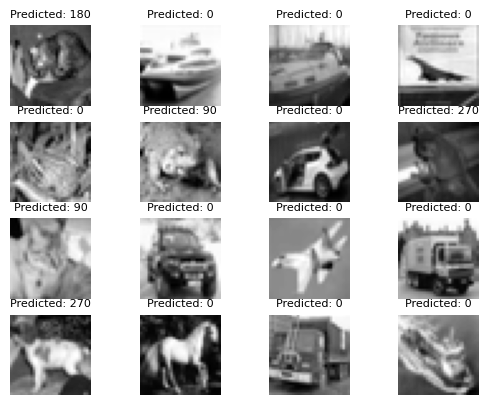

Accuracy : 68.05%


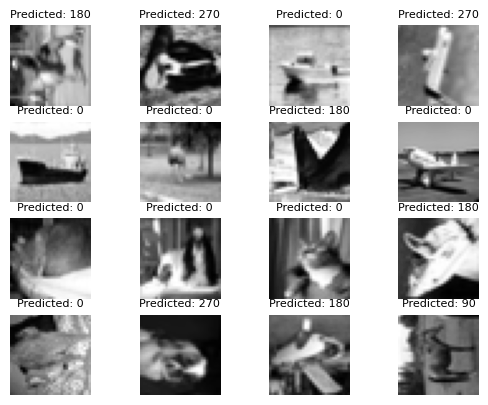

In [17]:
theta = [0, 90, 180, 270]

rot_model.eval()

batch = next(iter(testloader))
images, labels = batch

outputs = rot_model(images.to(device))
_, prediction = torch.max(outputs.data, 1)

for i in range(16):
  image = images[i].numpy().squeeze()
  image = image.mean(axis=0)
  plt.subplot(4,4, i+1)
  plt.imshow(image, cmap='gray')
  plt.title(f'Predicted: {theta[prediction[i]]}', fontsize= 8)
  plt.axis('off')
plt.show()

with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in testloader:
    labels = labels.to(device)
    images = images.to(device)

    rot_img = []
    rot_degrees = []

    for img in images:
      img = img
      # unsqueeze to add channel
      img = img.unsqueeze(0)
      img, theta = rot(img)
      rot_img.append(img)
      rot_degrees.append(torch.tensor(theta))

    x = torch.cat(rot_img, dim =0)
    theta = torch.stack(rot_degrees)

    x = x.to(device)
    theta = theta.to(device)

    outputs = rot_model(x.to(device))
    _, prediction = torch.max(outputs.data, 1)
    total += theta.size(0)
    correct += (prediction == theta).sum().item()
  print(f'Accuracy : {100 * correct / total}%')

theta = [0, 90, 180, 270]

for i in range(16):
  image = x[i].cpu().numpy().squeeze()
  image = image.mean(axis=0)
  plt.subplot(4,4, i+1)
  plt.imshow(image, cmap='gray')
  plt.title(f'Predicted: {theta[prediction[i]]}', fontsize= 8)
  plt.axis('off')
plt.show()
